## Imbalance Pricing Insights

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Preprocessing

In [17]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data.fillna(method='ffill', inplace=True)
    data['SettlementDate'] = pd.to_datetime(data['SettlementDate'])
    data['StartTime'] = pd.to_datetime(data['StartTime'])
    data.set_index('StartTime', inplace=True)
    data = data.sort_index()
    return data

train_test_files = [
    'train_1.csv',
    'train_2.csv',
    'train_3.csv',
    'train_4.csv',
    'train_5.csv',
    'test_1.csv'
]

test_1 = train_test_files[5]
test_1_df = pd.read_csv(test_1)

print(test_1_df.head())

  SettlementDate  SettlementPeriod             StartTime  \
0     2024-07-05                32  2024-07-05T14:30:00Z   
1     2024-07-05                33  2024-07-05T15:00:00Z   
2     2024-07-05                34  2024-07-05T15:30:00Z   
3     2024-07-05                35  2024-07-05T16:00:00Z   
4     2024-07-05                36  2024-07-05T16:30:00Z   

        CreatedDateTime  SystemSellPrice  SystemBuyPrice  BsadDefaulted  \
0  2024-07-06T15:14:32Z             46.6            46.6          False   
1  2024-07-06T15:44:30Z             45.0            45.0          False   
2  2024-07-06T16:14:31Z             49.0            49.0          False   
3  2024-07-06T16:44:32Z            102.9           102.9          False   
4  2024-07-06T17:14:30Z            110.0           110.0          False   

  PriceDerivationCode  ReserveScarcityPrice  NetImbalanceVolume  ...  \
0                   N                   0.0          -50.564581  ...   
1                   N                   0.0 

## Analysis

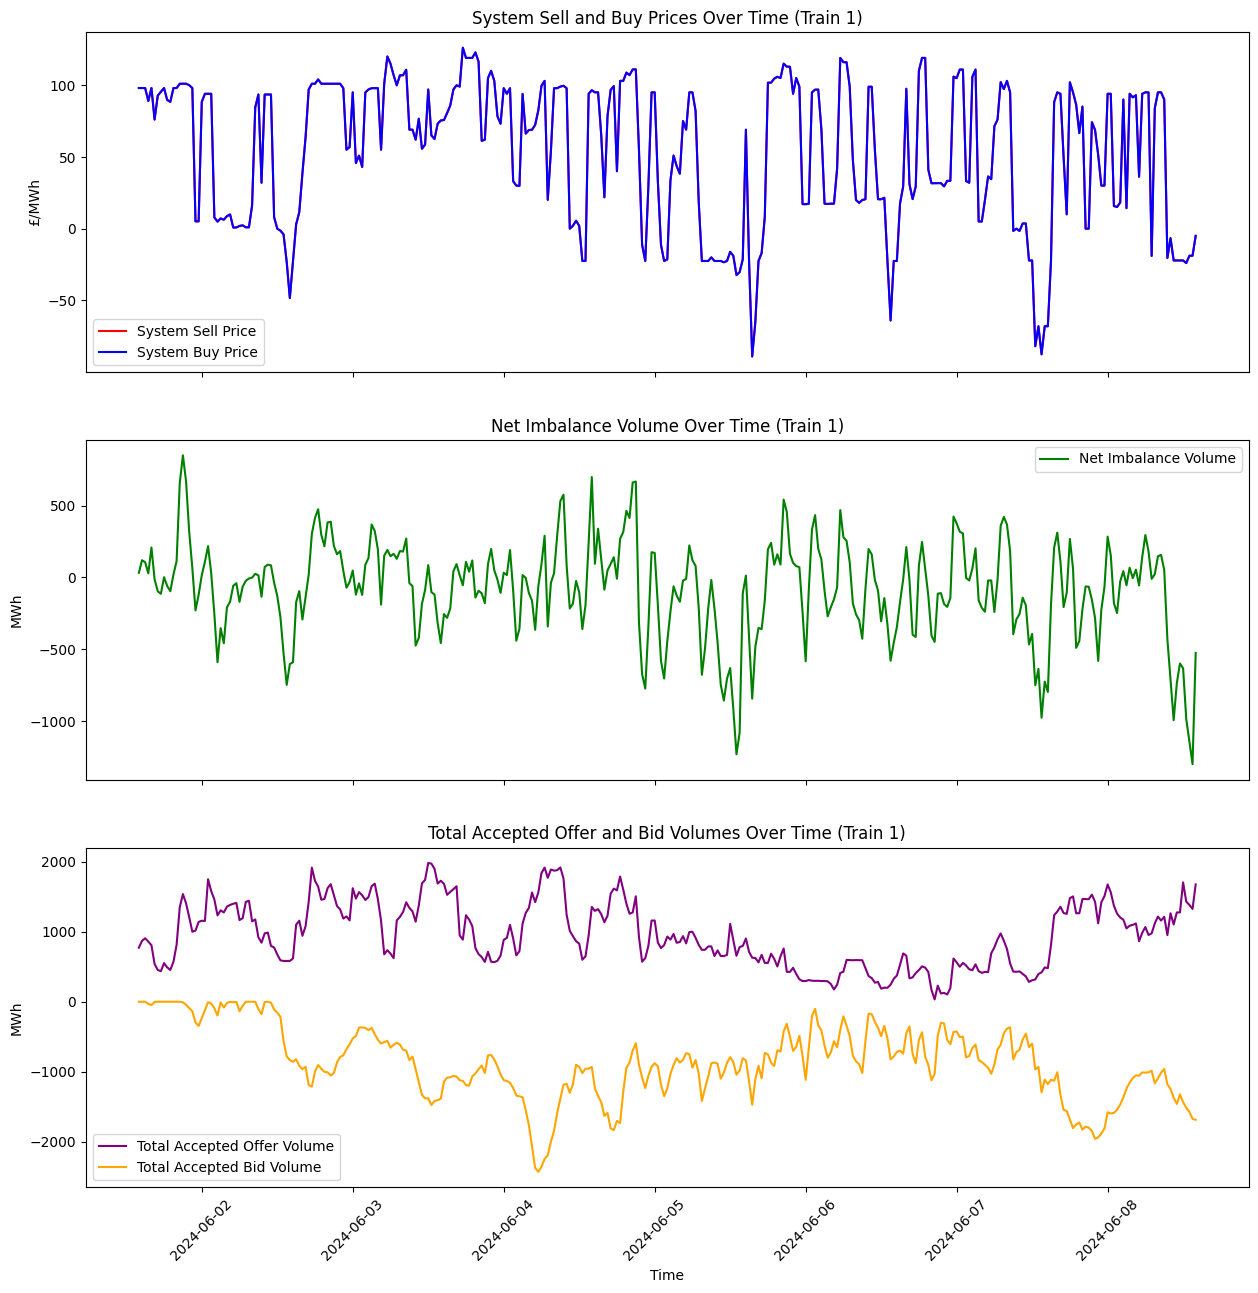

In [18]:
train_1_df = pd.read_csv("train_1.csv")

train_1_df['SettlementDate'] = pd.to_datetime(train_1_df['SettlementDate'])
train_1_df['StartTime'] = pd.to_datetime(train_1_df['StartTime'])

fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

axs[0].plot(train_1_df['StartTime'], train_1_df['SystemSellPrice'], label='System Sell Price', color='red')
axs[0].plot(train_1_df['StartTime'], train_1_df['SystemBuyPrice'], label='System Buy Price', color='blue')
axs[0].set_title('System Sell and Buy Prices Over Time (Train 1)')
axs[0].set_ylabel('£/MWh')
axs[0].legend()

axs[1].plot(train_1_df['StartTime'], train_1_df['NetImbalanceVolume'], label='Net Imbalance Volume', color='green')
axs[1].set_title('Net Imbalance Volume Over Time (Train 1)')
axs[1].set_ylabel('MWh')
axs[1].legend()

axs[2].plot(train_1_df['StartTime'], train_1_df['TotalAcceptedOfferVolume'], label='Total Accepted Offer Volume', color='purple')
axs[2].plot(train_1_df['StartTime'], train_1_df['TotalAcceptedBidVolume'], label='Total Accepted Bid Volume', color='orange')
axs[2].set_title('Total Accepted Offer and Bid Volumes Over Time (Train 1)')
axs[2].set_ylabel('MWh')
axs[2].legend()

axs[2].set_xlabel('Time')

plt.xticks(rotation=45)
plt.show()

## Model Training - Price

In [ ]:
all_train_data = pd.concat([load_and_preprocess_data(file) for file in train_test_files])

test_file_path = 'test_1.csv'
test_data = load_and_preprocess_data(test_file_path)

train_price_data = all_train_data[['SystemSellPrice']].values
test_price_data = test_data[['SystemSellPrice']].values

train_series = pd.Series(train_price_data.flatten(), index=all_train_data.index)
test_series = pd.Series(test_price_data.flatten(), index=test_data.index)

combined_price_data = np.concatenate((train_price_data, test_price_data), axis=0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_price_data)

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=50))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X, y, batch_size=32, epochs=50)

Epoch 1/50
72/72 [==============================] - 9s 43ms/step - loss: 0.0453
Epoch 2/50
72/72 [==============================] - 3s 42ms/step - loss: 0.0263
Epoch 3/50
72/72 [==============================] - 2s 26ms/step - loss: 0.0251
Epoch 4/50
72/72 [==============================] - 2s 26ms/step - loss: 0.0240
Epoch 5/50
72/72 [==============================] - 2s 26ms/step - loss: 0.0246
Epoch 6/50
72/72 [==============================] - 2s 27ms/step - loss: 0.0222
Epoch 7/50
72/72 [==============================] - 2s 26ms/step - loss: 0.0206
Epoch 8/50
72/72 [==============================] - 3s 37ms/step - loss: 0.0202
Epoch 9/50
72/72 [==============================] - 2s 34ms/step - loss: 0.0188
Epoch 10/50
72/72 [==============================] - 2s 27ms/step - loss: 0.0179
Epoch 11/50
72/72 [==============================] - 2s 27ms/step - loss: 0.0165
Epoch 12/50
72/72 [==============================] - 2s 33ms/step - loss: 0.0161
Epoch 13/50
72/72 [==================

## Model Evaluation - Price

11/11 [==============================] - 2s 9ms/step
MSE: 889.6546507884278
RMSE: 29.82707915281729
MAE: 22.571276680650104
R2 Score: 0.22286856315930337


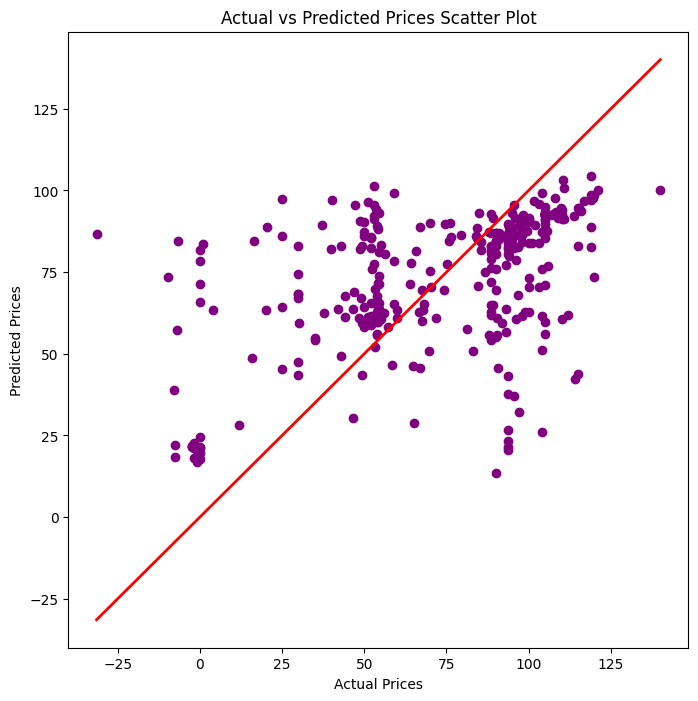

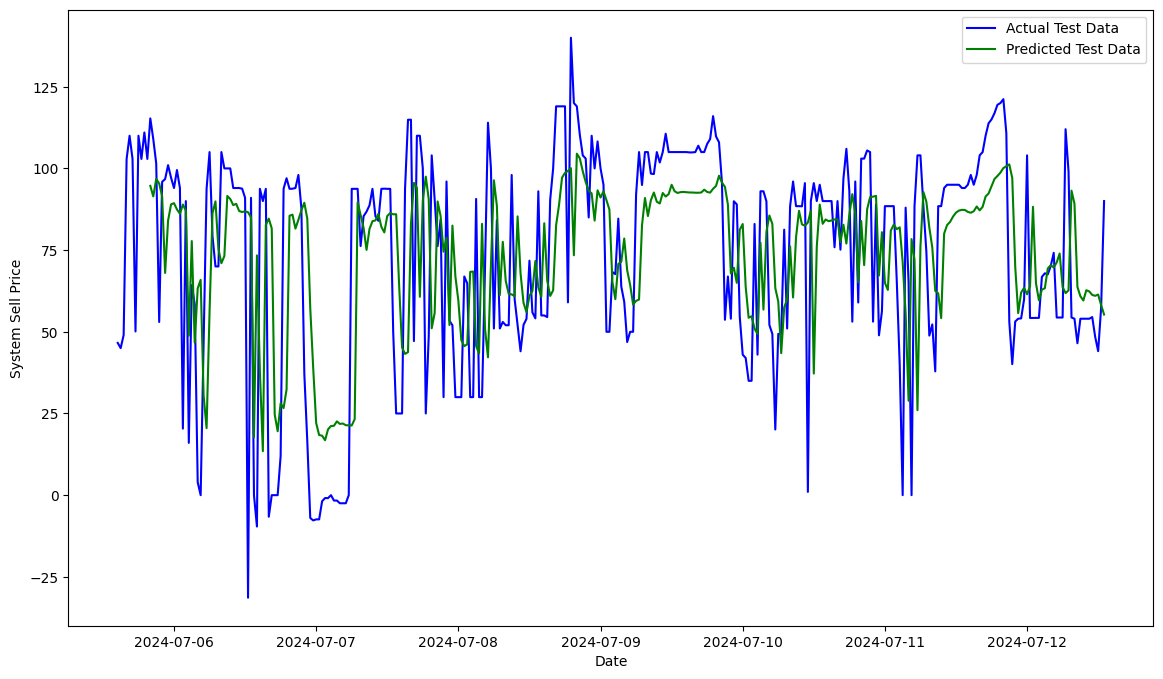

In [28]:
test_scaled_data = scaler.transform(test_price_data)
X_test, y_test = create_dataset(test_scaled_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

test_series_adjusted = test_series[time_step + 1:]

test_predictions = lstm_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

mse = mean_squared_error(test_series_adjusted, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_series_adjusted, test_predictions)
r2 = r2_score(test_series_adjusted, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

test_predictions_df = pd.DataFrame(test_predictions, index=test_series_adjusted.index, columns=['Predicted Price'])

plt.figure(figsize=(8, 8))
plt.scatter(test_series_adjusted, test_predictions, color='purple')
plt.plot([test_series_adjusted.min(), test_series_adjusted.max()], [test_series_adjusted.min(), test_series_adjusted.max()], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices Scatter Plot')
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(test_predictions_df.index, test_predictions_df['Predicted Price'], label='Predicted Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('System Sell Price')
plt.legend()
plt.show()

## Model Training - Accepted Offer Volume

In [29]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data.fillna(method='ffill', inplace=True)
    data['SettlementDate'] = pd.to_datetime(data['SettlementDate'])
    data['StartTime'] = pd.to_datetime(data['StartTime'])
    data.set_index('StartTime', inplace=True)
    data = data.sort_index()
    return data

train_test_files = [
    'train_1.csv',
    'train_2.csv',
    'train_3.csv',
    'train_4.csv',
    'train_5.csv'
]

all_train_data = pd.concat([load_and_preprocess_data(file) for file in train_test_files])

test_file_path = 'test_1.csv'
test_data = load_and_preprocess_data(test_file_path)

train_volume_data = all_train_data[['TotalAcceptedOfferVolume']].values
test_volume_data = test_data[['TotalAcceptedOfferVolume']].values

combined_volume_data = np.concatenate((train_volume_data, test_volume_data), axis=0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_volume_data)

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=50))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X, y, batch_size=32, epochs=50)

Epoch 1/50
62/62 [==============================] - 8s 27ms/step - loss: 0.0212
Epoch 2/50
62/62 [==============================] - 2s 29ms/step - loss: 0.0147
Epoch 3/50
62/62 [==============================] - 2s 28ms/step - loss: 0.0101
Epoch 4/50
62/62 [==============================] - 2s 39ms/step - loss: 0.0084
Epoch 5/50
62/62 [==============================] - 2s 36ms/step - loss: 0.0077
Epoch 6/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0060
Epoch 7/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0054
Epoch 8/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0048
Epoch 9/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0046
Epoch 10/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0042
Epoch 11/50
62/62 [==============================] - 2s 35ms/step - loss: 0.0040
Epoch 12/50
62/62 [==============================] - 3s 41ms/step - loss: 0.0039
Epoch 13/50
62/62 [==================

## Model Evaluation - Volume

11/11 [==============================] - 1s 9ms/step
MSE: 30139.02781578129
RMSE: 173.60595558845696
MAE: 130.18930671051166
R2 Score: 0.7708270743038639


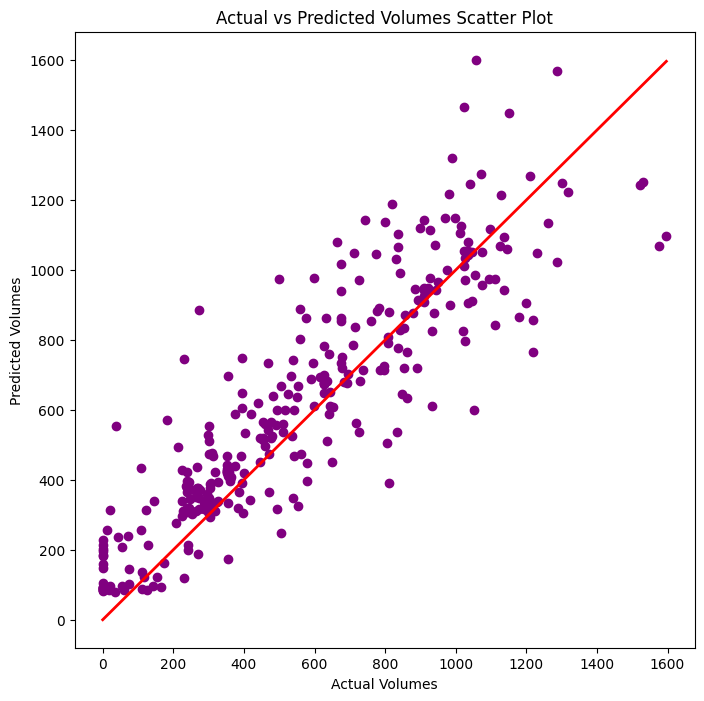

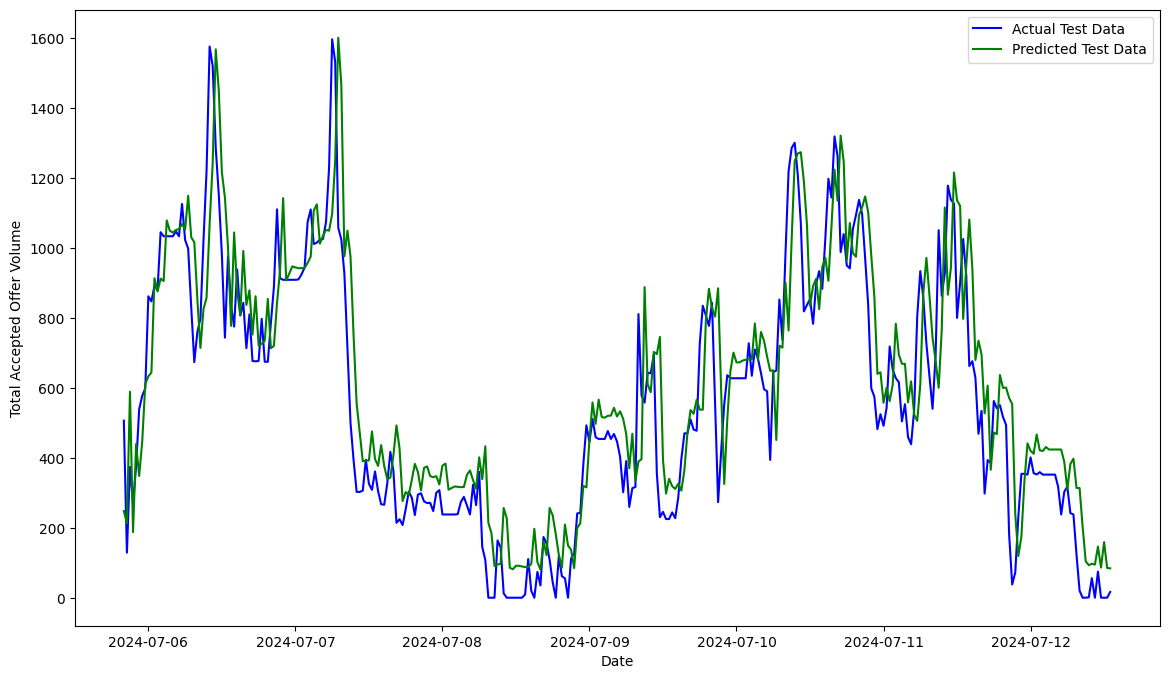

In [30]:
test_scaled_data = scaler.transform(test_volume_data)
X_test, y_test = create_dataset(test_scaled_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

test_predictions = lstm_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

test_series_adjusted = test_data['TotalAcceptedOfferVolume'][time_step + 1:]

mse = mean_squared_error(test_series_adjusted, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_series_adjusted, test_predictions)
r2 = r2_score(test_series_adjusted, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

test_predictions_df = pd.DataFrame(test_predictions, index=test_series_adjusted.index, columns=['Predicted Volume'])

plt.figure(figsize=(8, 8))
plt.scatter(test_series_adjusted, test_predictions, color='purple')
plt.plot([test_series_adjusted.min(), test_series_adjusted.max()], [test_series_adjusted.min(), test_series_adjusted.max()], color='red', linewidth=2)
plt.xlabel('Actual Volumes')
plt.ylabel('Predicted Volumes')
plt.title('Actual vs Predicted Volumes Scatter Plot')
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(test_series_adjusted.index, test_series_adjusted, label='Actual Test Data', color='blue')
plt.plot(test_predictions_df.index, test_predictions_df['Predicted Volume'], label='Predicted Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('Total Accepted Offer Volume')
plt.legend()
plt.show()

## Model Training - Net Imbalance Volume

In [31]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data.fillna(method='ffill', inplace=True)
    data['SettlementDate'] = pd.to_datetime(data['SettlementDate'])
    data['StartTime'] = pd.to_datetime(data['StartTime'])
    data.set_index('StartTime', inplace=True)
    data = data.sort_index()
    return data

train_test_files = [
    'train_1.csv',
    'train_2.csv',
    'train_3.csv',
    'train_4.csv',
    'train_5.csv'
]

all_train_data = pd.concat([load_and_preprocess_data(file) for file in train_test_files])

test_file_path = 'test_1.csv'
test_data = load_and_preprocess_data(test_file_path)

train_niv_data = all_train_data[['NetImbalanceVolume']].values
test_niv_data = test_data[['NetImbalanceVolume']].values

combined_niv_data = np.concatenate((train_niv_data, test_niv_data), axis=0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_niv_data)

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=50))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X, y, batch_size=32, epochs=50)

Epoch 1/50
62/62 [==============================] - 9s 35ms/step - loss: 0.0270
Epoch 2/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0135
Epoch 3/50
62/62 [==============================] - 2s 26ms/step - loss: 0.0138
Epoch 4/50
62/62 [==============================] - 2s 26ms/step - loss: 0.0132
Epoch 5/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0127
Epoch 6/50
62/62 [==============================] - 2s 30ms/step - loss: 0.0122
Epoch 7/50
62/62 [==============================] - 3s 43ms/step - loss: 0.0117
Epoch 8/50
62/62 [==============================] - 2s 30ms/step - loss: 0.0114
Epoch 9/50
62/62 [==============================] - 2s 26ms/step - loss: 0.0106
Epoch 10/50
62/62 [==============================] - 2s 27ms/step - loss: 0.0101
Epoch 11/50
62/62 [==============================] - 2s 28ms/step - loss: 0.0091
Epoch 12/50
62/62 [==============================] - 2s 30ms/step - loss: 0.0082
Epoch 13/50
62/62 [==================

11/11 [==============================] - 2s 9ms/step
MSE: 45953.82601143528
RMSE: 214.36843520312237
MAE: 167.89512390198354
R2 Score: 0.20173916151965587


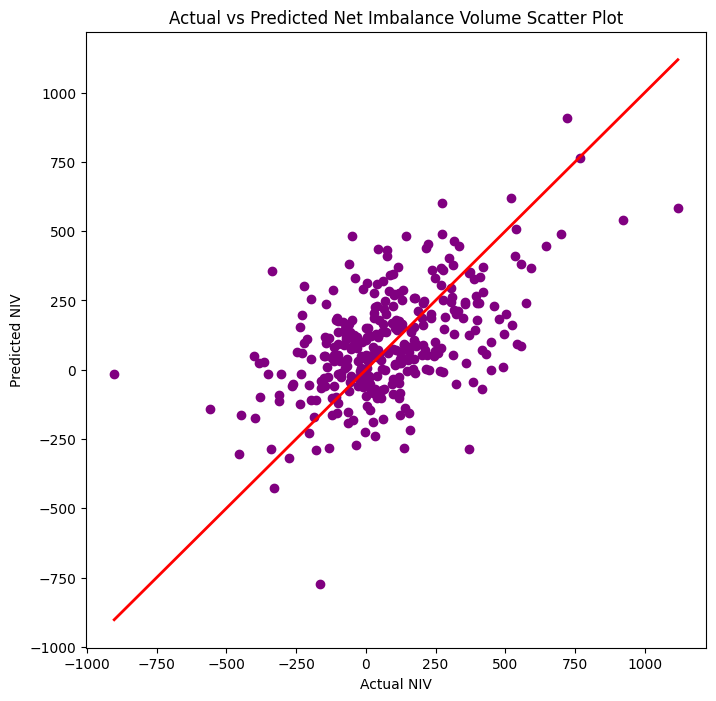

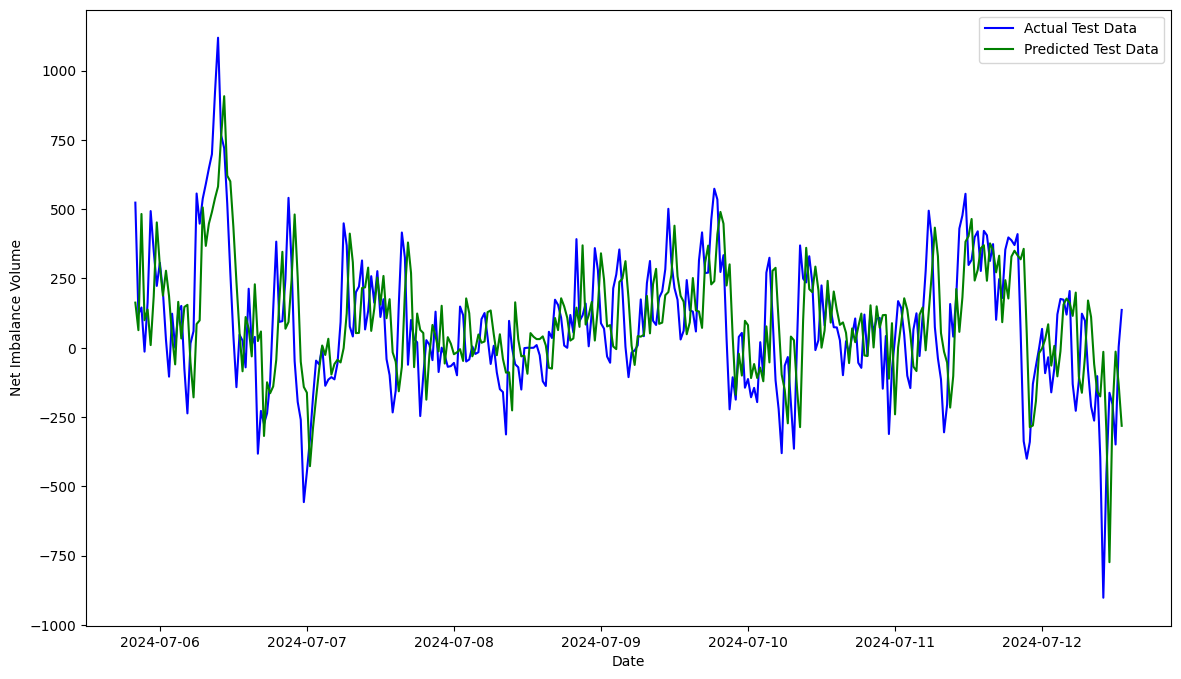

In [32]:
test_scaled_data = scaler.transform(test_niv_data)
X_test, y_test = create_dataset(test_scaled_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

test_predictions = lstm_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

test_series_adjusted = test_data['NetImbalanceVolume'][time_step + 1:]

mse = mean_squared_error(test_series_adjusted, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_series_adjusted, test_predictions)
r2 = r2_score(test_series_adjusted, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

test_predictions_df = pd.DataFrame(test_predictions, index=test_series_adjusted.index, columns=['Predicted NIV'])

plt.figure(figsize=(8, 8))
plt.scatter(test_series_adjusted, test_predictions, color='purple')
plt.plot([test_series_adjusted.min(), test_series_adjusted.max()], [test_series_adjusted.min(), test_series_adjusted.max()], color='red', linewidth=2)
plt.xlabel('Actual NIV')
plt.ylabel('Predicted NIV')
plt.title('Actual vs Predicted Net Imbalance Volume Scatter Plot')
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(test_series_adjusted.index, test_series_adjusted, label='Actual Test Data', color='blue')
plt.plot(test_predictions_df.index, test_predictions_df['Predicted NIV'], label='Predicted Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('Net Imbalance Volume')
plt.legend()
plt.show()